## DAMAGE TOLERANCE AND THREAD ASSESMENT

Let's consider a Barely Visible Impact Damage (BVID) on a composite skin panel with integrated stringers (Category 1, CSET 4.3 Addressing Damage and Defects, slides 58-61).
The process for damage tolerance evaluation would be (AC 20-107B, Paragrah 8. Proof of Structure -  Fatigue and Damage Tolerance):

Damage assessment  and Inspection (slides 31-32, 36, 124):
   - Impact testing at various energies to establish BVID threshold.
   - Internal damage extend mapping (NDIs)
   - Microscopy to understand damage morphology.

Analysis (slide 60):
   - FEM of damaged region.
   - Prediction of residual strength.
   - Assessment of damage growth potential.
   - Must withstand Ultimate Load capability
   - Maintain structural integrity through aircraft's lifecycle.

Testing approach (slide 9, CMH-17 Building Block Testing Approach):
   - Static strength tests of damaged specimens.
   - Fatigue testing under spectrum loading.
   - Full-scale validation testing.
   - Envirommental effects must be considered.

Category 1 damage design drivers: 

Minimum Skin Thickness:
   - Must be sufficient to prevent penetration.
   - Should provide adequate impact resistance

Stringer Spacing (slide 113):
   - Affects panel buckling behavior with damage.
   - Influences damage containment capability.

Laminate Stacking (slide 14):
    - Material and stacking sequence affects damage distribution.
    - Optimization needed between matrix cracks, delamination, and fiber breakage.



One of the important aspects of the outlined process is determining the residual strength with statistical significance so a B-Basis, let's say, in the presence of BVID can be established. </br>
B-Basis must account for environmental effects.  If we have three main environments of interest (in addition to RTA), which are Cold Temperature Dry, Room Temperature Wet and Elevated Temperature Wet, do you need to do enough tests at each environment to get the scatter and the B-Basis for each and, if yes, how many tests would you recommend?

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.optimize import fsolve
from scipy.stats import anderson_ksamp
from scipy import stats
from matplotlib.patches import Patch


##### Approach 1: Full B-Basis Calculation

In [3]:
# Approach 1: Full B-Basis Calculation
def b_basis_sample_size(sigma=.06, d_error=.05):
    """
    Calculation of the required sample size for B-basis values (90% probability with 95% confidence)
    Z-scores (one sided):
    90% probability = Z_alpha
    95% confidence = Z_beta
    Parameters:
    sigma = coefficient of variation
    d_error =  acceptable error
    Returns:
    n = sample size

    """
    Z_alpha = 1.645  
    Z_beta = 1.96   
    n = ((Z_alpha + Z_beta) * sigma/d_error)**2
    return np.ceil(n)

##### Approach 2: Environmental Knockdown Factors

In [4]:
def knockdown_sample_size(std_dev=.06, k_error=.04):
    """
    Calculation of the sample size for environmental knockdown factors
    t_value = margin of error or confidence interval for a sample mean (t_value for 95% confidence = 2.201)
    Parameters:
    std_dev = standard deviation
    k_error = margin of error
    Returns:
    n = sample size
    """
    t_value = 2.201  
    n = (t_value * std_dev/k_error)**2
    return np.ceil(n)

##### Approach 3: Statistical Power Analysis

In [5]:
def validation_sample_size(effect_size=1.0, power=0.8):
    """
    Calculation of the sample size for validation testing based on power analysis
    Z-score:  Z_alpha for 90% probability = 1.645
    Parameters:
    effect size = magnitude of the difference between groups
    power = probability that the test will correctly reject the false null hypothesis 
    Returns:
    n = sample size
    """
    Z_alpha = 1.645
    Z_beta = stats.norm.ppf(power)
    n = ((Z_alpha + Z_beta)/effect_size)**2
    return np.ceil(n)

##### Composite test data analysis using Anderson-Darling normalization

In [ ]:
def composite_data_analysis(n_samples, mean_strength=100, cv=0.06):
    """
    Analyzes composite test data
    Parameters:
    n_samples = sample size
    mean_strength = average value of strength measurements taken from multiple specimens of a material
    cv =  coefficient of variation (ratio of the standard deviation to the mean)
    Returns:
    data = simulation of test data (normal distribution)
    mean = mean value of the simulated data
    std =  std deviation of the simulated data
    b_basis = B-basis value
    ad_stat = the Anderson-Darling test statistic.
    ad_crit =the critical values for this distribution.
    ad_sig = the significance levels for the corresponding critical values in percents

    Anderson-Darling test statistics: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html

    """
    std_dev = mean_strength * cv
    data = np.random.normal(mean_strength, std_dev, n_samples)
    
    # Mean and standard deviation of the simulated data
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    
    # B-basis value at 90% probability
    k_value = stats.norm.ppf(0.90) 
    b_basis = mean - k_value * std

     # Anderson-Darling test for normality
    ad_stat, ad_crit, ad_sig = stats.anderson(data)
    
    return data, mean, std, b_basis, ad_stat, ad_crit, ad_sig

##### k-sample Anderson-Darling test

In [ ]:
def anderson_ksamp_test(samples_dict):
    """
    Runs k-sample Anderson-Darling test on multiple environmental conditions
    
    Parameters:
    samples_dict: dictionary with environmental conditions as keys and data arrays as values
    
    Returns:
    statistic: Anderson-Darling test statistic
    critical_values: critical values for different significance levels
    p_value: p-value of the test
    
    Anderson K-sample: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson_ksamp.html
    """
    # Extract samples from dictionary
    samples = list(samples_dict.values())
    
    # Perform k-sample Anderson-Darling test
    method = stats.PermutationMethod(n_resamples=9999, random_state=42)
    statistic, critical_values, p_value = anderson_ksamp(samples, method=method)

    # For composite material certification and structural analysis, we want 0.05 (5%) as the standard threshold fir critical values
    critical_value5 = critical_values[2]
    
    return statistic, critical_value5, p_value

#### Data visualization functions

In [95]:
def plot_environmental_distributions(results_dict):
    """
    Create violin plot comparing distributions across environmental conditions
    """
    plt.style.use('seaborn-v0_8-pastel')
    plt.figure(figsize=(12, 6))
    
    # Prepare data for plotting
    data_list = []
    for condition, data in results_dict.items():
        df = pd.DataFrame({
            'Strength': data['data'],
            'Condition': condition
        })
        data_list.append(df)
    
    plot_data = pd.concat(data_list)
    
    # Create violin plot
    sns.violinplot(x='Condition', y='Strength', data=plot_data)
    plt.title('Distribution Comparison Across Environmental Conditions')
    plt.grid(True)
    plt.show()

In [97]:
def analysis_visualization(results_dict):
    """
    Comprehensive visualization:
    1. Distribution plots for each condition
    2. Box plots with individual points
    3. Q-Q plots for normality assessment
    4. B-basis visualization
    """
    plt.style.use('seaborn-v0_8-pastel')
    conditions = list(results_dict.keys())
    n_conditions = len(conditions)
    
    # Create figure with GridSpec
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 2)
    
    # 1. Distribution Plot
    ax1 = fig.add_subplot(gs[0, :])
    colors = plt.cm.Set3(np.linspace(0, 1, n_conditions))
    
    for idx, (condition, color) in enumerate(zip(conditions, colors)):
        data = results_dict[condition]['data']
        sns.kdeplot(data, label=condition, color=color, ax=ax1)
        ax1.axvline(results_dict[condition]['b_basis'], 
                   color=color, linestyle='--', alpha=0.5)
    
    ax1.set_title('Distribution Comparison with B-basis Values')
    ax1.set_xlabel('Strength')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True)

    # 2. Box Plot with Individual Points
    ax2 = fig.add_subplot(gs[1, 0])
    data_list = []
    for condition in conditions:
        data = results_dict[condition]['data']
        data_list.append(pd.DataFrame({
            'Strength': data,
            'Condition': condition
        }))
    plot_data = pd.concat(data_list)
    
    sns.boxplot(x='Condition', y='Strength', data=plot_data, ax=ax2)
    sns.swarmplot(x='Condition', y='Strength', data=plot_data, 
                 color='0.25', size=4, alpha=0.5, ax=ax2)
    ax2.set_title('Box Plot with Individual Points')
    ax2.grid(True)

    # 3. Q-Q Plots
    ax3 = fig.add_subplot(gs[1, 1])
    for condition, color in zip(conditions, colors):
        data = results_dict[condition]['data']
        stats.probplot(data, dist="norm", plot=ax3)
    ax3.set_title('Q-Q Plots for Normality Assessment')
    ax3.grid(True)

    # 4. B-basis Comparison
    ax4 = fig.add_subplot(gs[2, :])
    x_pos = np.arange(len(conditions))
    means = [results_dict[c]['mean'] for c in conditions]
    b_basis = [results_dict[c]['b_basis'] for c in conditions]
    std_devs = [results_dict[c]['std'] for c in conditions]

    # Plot bars for means and B-basis
    bar_width = 0.35
    ax4.bar(x_pos - bar_width/2, means, bar_width, label='Mean', alpha=0.8)
    ax4.bar(x_pos + bar_width/2, b_basis, bar_width, label='B-basis', alpha=0.8)
    
    # Add error bars for standard deviation
    ax4.errorbar(x_pos - bar_width/2, means, yerr=std_devs, fmt='none', 
                color='black', capsize=5)

    ax4.set_xticks(x_pos)
    ax4.set_xticklabels(conditions)
    ax4.set_title('Mean vs B-basis Comparison')
    ax4.set_ylabel('Strength')
    ax4.legend()
    ax4.grid(True)

    plt.tight_layout()
    plt.show()

In [98]:
def statistical_summary_plot(results_dict):
    """
    Statistical summary plot:
    1. Coefficient of Variation
    2. Anderson-Darling Statistics
    3. Knockdown Factors
    """
    plt.style.use('seaborn-v0_8-pastel')
    conditions = list(results_dict.keys())
    n_metrics = 3
    
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 12))
    
    # 1. Coefficient of Variation
    cv_values = [results_dict[c]['std']/results_dict[c]['mean'] for c in conditions]
    axes[0].bar(conditions, cv_values)
    axes[0].set_title('Coefficient of Variation')
    axes[0].grid(True)
    
    # 2. Anderson-Darling Statistics
    ad_stats = [results_dict[c]['anderson_stat'] for c in conditions]
    axes[1].bar(conditions, ad_stats)
    axes[1].set_title('Anderson-Darling Statistics')
    axes[1].grid(True)
    
    # 3. Knockdown Factors (relative to RTD)
    rtd_mean = results_dict['RTD']['mean']
    kd_factors = [results_dict[c]['mean']/rtd_mean for c in conditions]
    axes[2].bar(conditions, kd_factors)
    axes[2].set_title('Knockdown Factors (relative to RTD)')
    axes[2].grid(True)
    axes[2].axhline(y=1.0, color='r', linestyle='--')
    
    plt.tight_layout()
    plt.show()

In [105]:
def correlation_matrix(results_dict):
    """
    Correlation matrix between different metrics
    """
    metrics_dict = {
        'Mean': [results_dict[c]['mean'] for c in results_dict],
        'Std Dev': [results_dict[c]['std'] for c in results_dict],
        'B-basis': [results_dict[c]['b_basis'] for c in results_dict],
        'AD Stat': [results_dict[c]['anderson_stat'] for c in results_dict]
    }
    
    metrics_df = pd.DataFrame(metrics_dict, index=list(results_dict.keys()))
    correlation_matrix = metrics_df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='Oranges', center=0)
    plt.title('Correlation Matrix of Statistical Metrics')
    plt.show()

#### Environmental conditions
RTD: Room Temperature Dry</br>
CTD: Cold Temperature Dry</br>
RTW: Room Temperature Wet</br>
ETW: Elevated Temperature Wet</br>

In [100]:
# Environmental conditions (to do: replace by a @Dataclass)
def environmental_conditions():
    conditions = {
    'RTD': {'mean': 100, 'cv': 0.06},
    'CTD': {'mean': 105, 'cv': 0.06},
    'RTW': {'mean': 95, 'cv': 0.06},
    'ETW': {'mean': 90, 'cv': 0.06}
    }
    return conditions 

##### Environmental Condition Analysis

In [101]:
def statistical_analysis(conditions):
    results = {}
    samples_for_ksamp = {}
    # Analyze each condition
    for condition, params in conditions.items():
        if condition == 'RTD':
            n_samples = int(b_basis_sample_size())
        else:
            n_samples = int(knockdown_sample_size())
            
        data, mean, std, b_basis, ad_stat, ad_crit, ad_sig = composite_data_analysis(
            n_samples,
            mean_strength=params['mean'],
            cv=params['cv']
        )
        
        results[condition] = {
            'data': data,
            'mean': mean,
            'std': std,
            'b_basis': b_basis,
            'anderson_stat': ad_stat,
            'anderson_crit': ad_crit,
            'anderson_sig': ad_sig
        }
        
        samples_for_ksamp[condition] = data
        # Print results
        # print(f"\nResults for {condition}:")
        # print(f"Mean: {mean:.2f}")
        # print(f"Standard Deviation: {std:.2f}")
        # print(f"B-basis value: {b_basis:.2f}")
        # print(f"Anderson-Darling statistic: {ad_stat:.3f}")
        # print("Anderson-Darling significance levels:", ad_sig)
        # print("Anderson-Darling critical values:", ad_crit)
    
    return results, samples_for_ksamp

In [102]:
conditions = environmental_conditions()
results, samples_for_ksamp = statistical_analysis(conditions)

#### Perform k-sample Anderson-Darling test
##### Null Hypothesis:

All samples come from the same distribution, i.e, all environmental conditions (RTD, CTD, RTW, ETW) have the same strength distribution.

#### Alternative Hypothesis:


At least one sample comes from a different distribution, i.e, at least one environmental condition has a different strength distribution.

In [103]:
ksamp_stat, ksamp_crit, ksamp_pvalue = anderson_ksamp_test(samples_for_ksamp)

print("\nK-sample Anderson-Darling test results:")
print(f"Statistic: {ksamp_stat:.3f}")
print(f"Critical value: {ksamp_crit:.3f}")
print(f"P-value: {ksamp_pvalue:.4f}")

# Reject/Validation of null hypothesis
alpha = 0.05
if ksamp_pvalue < alpha:
    print("\nThe distributions are significantly different (reject null hypothesis)")
else:
    print("\nFailed to reject the null hypothesis - distributions may be similar")


K-sample Anderson-Darling test results:
Statistic: 13.409
Critical value: 1.916
P-value: 0.0001

The distributions are significantly different (reject null hypothesis)


#### Statistic Analysis Visualization

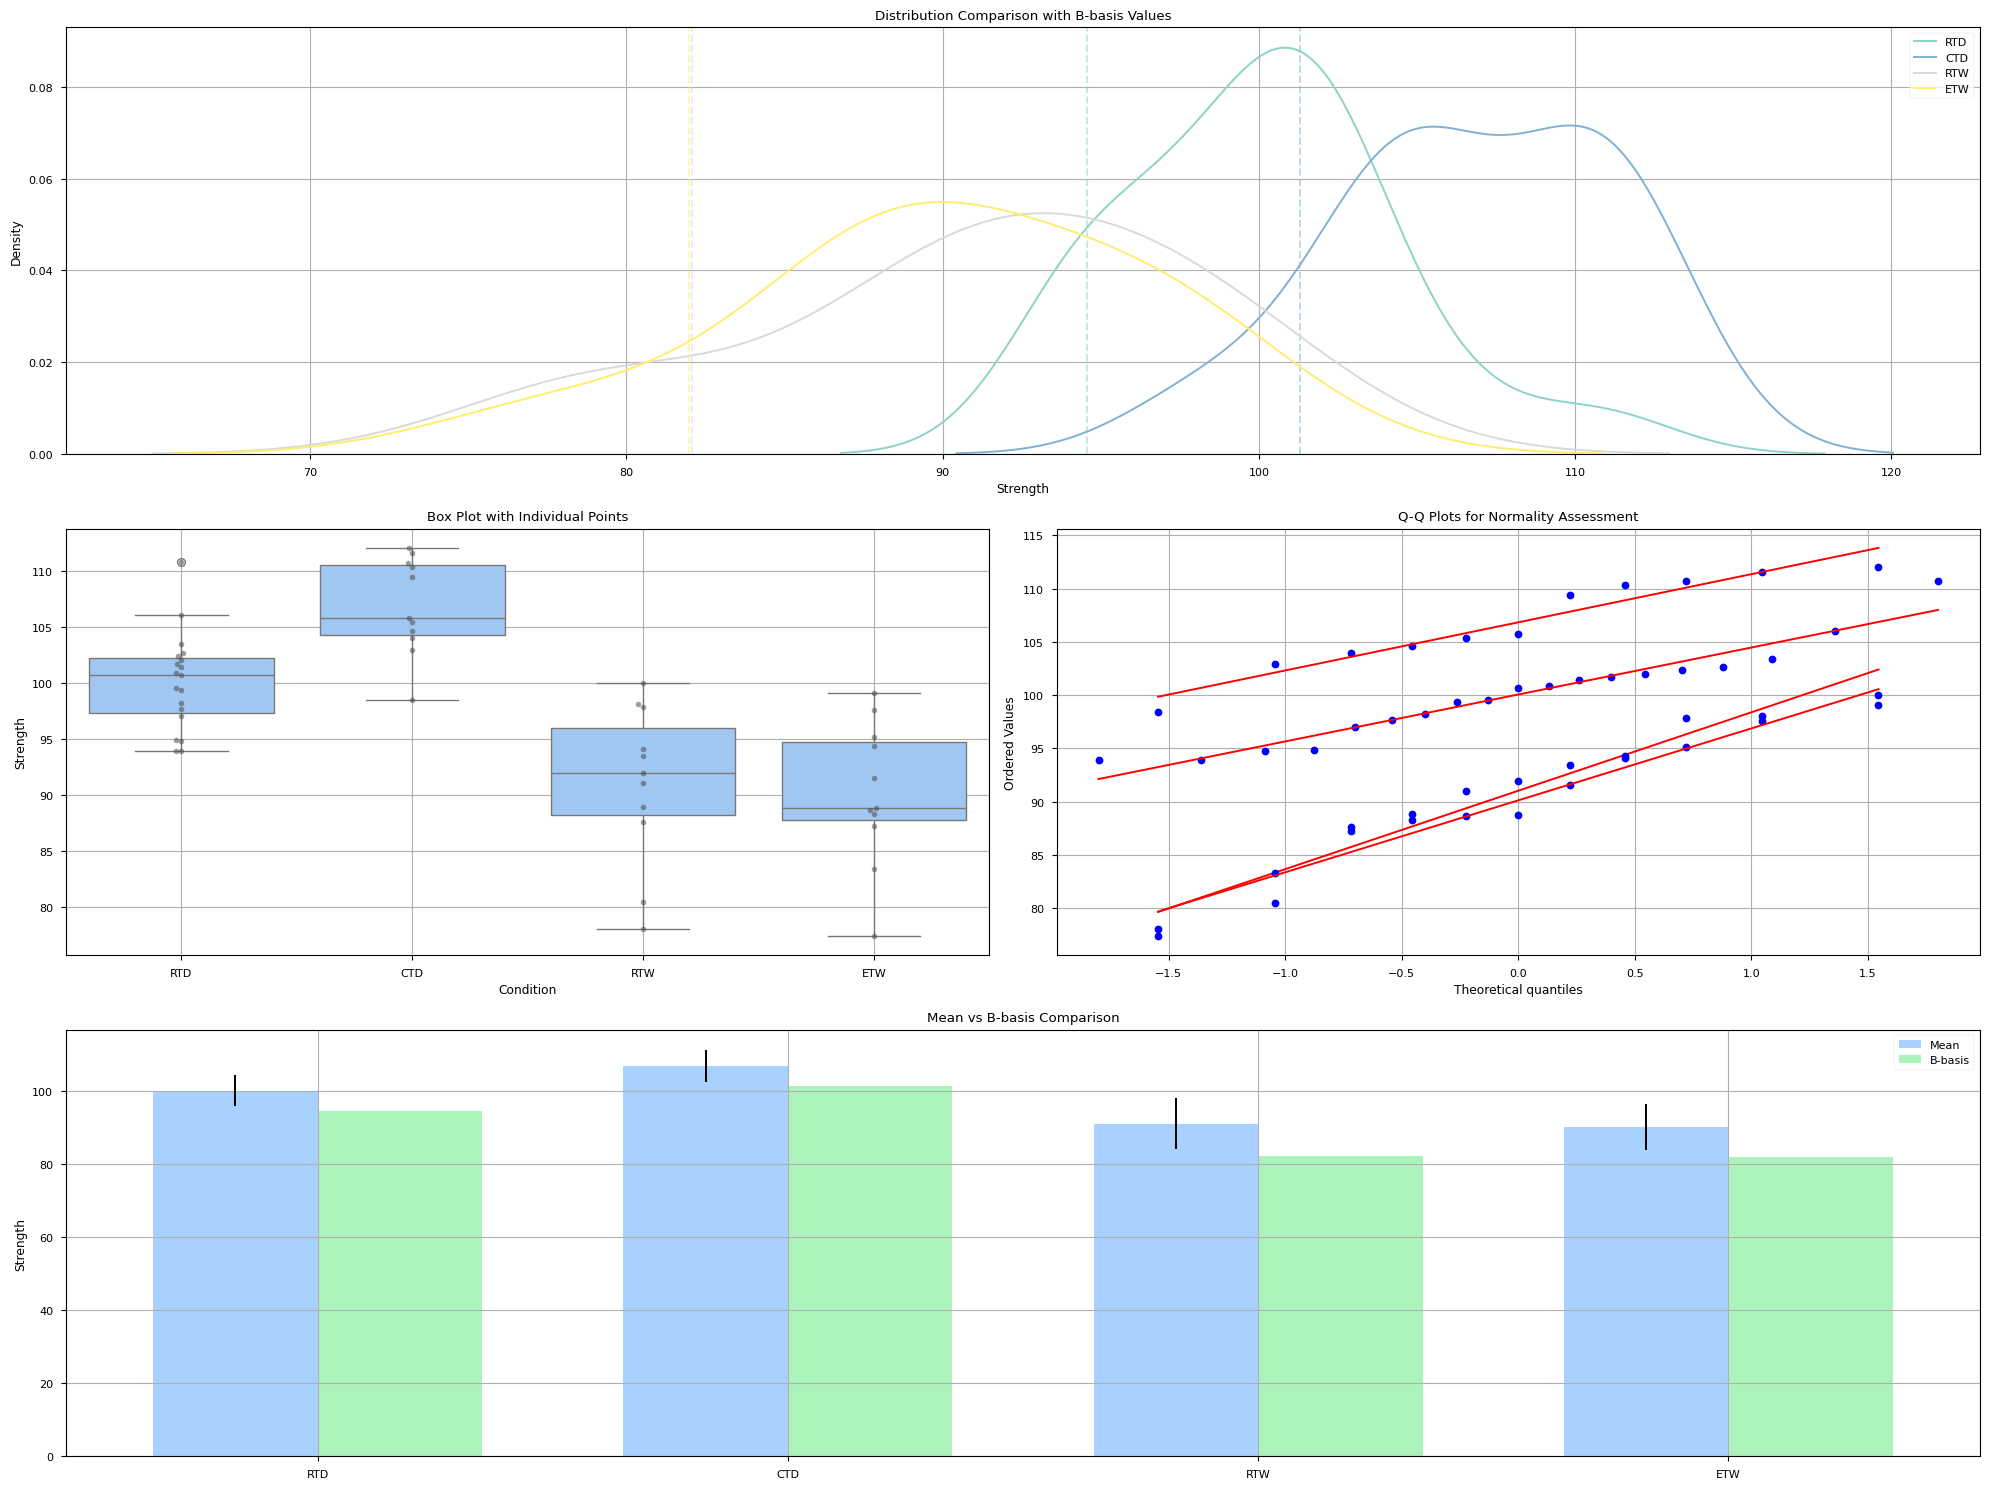

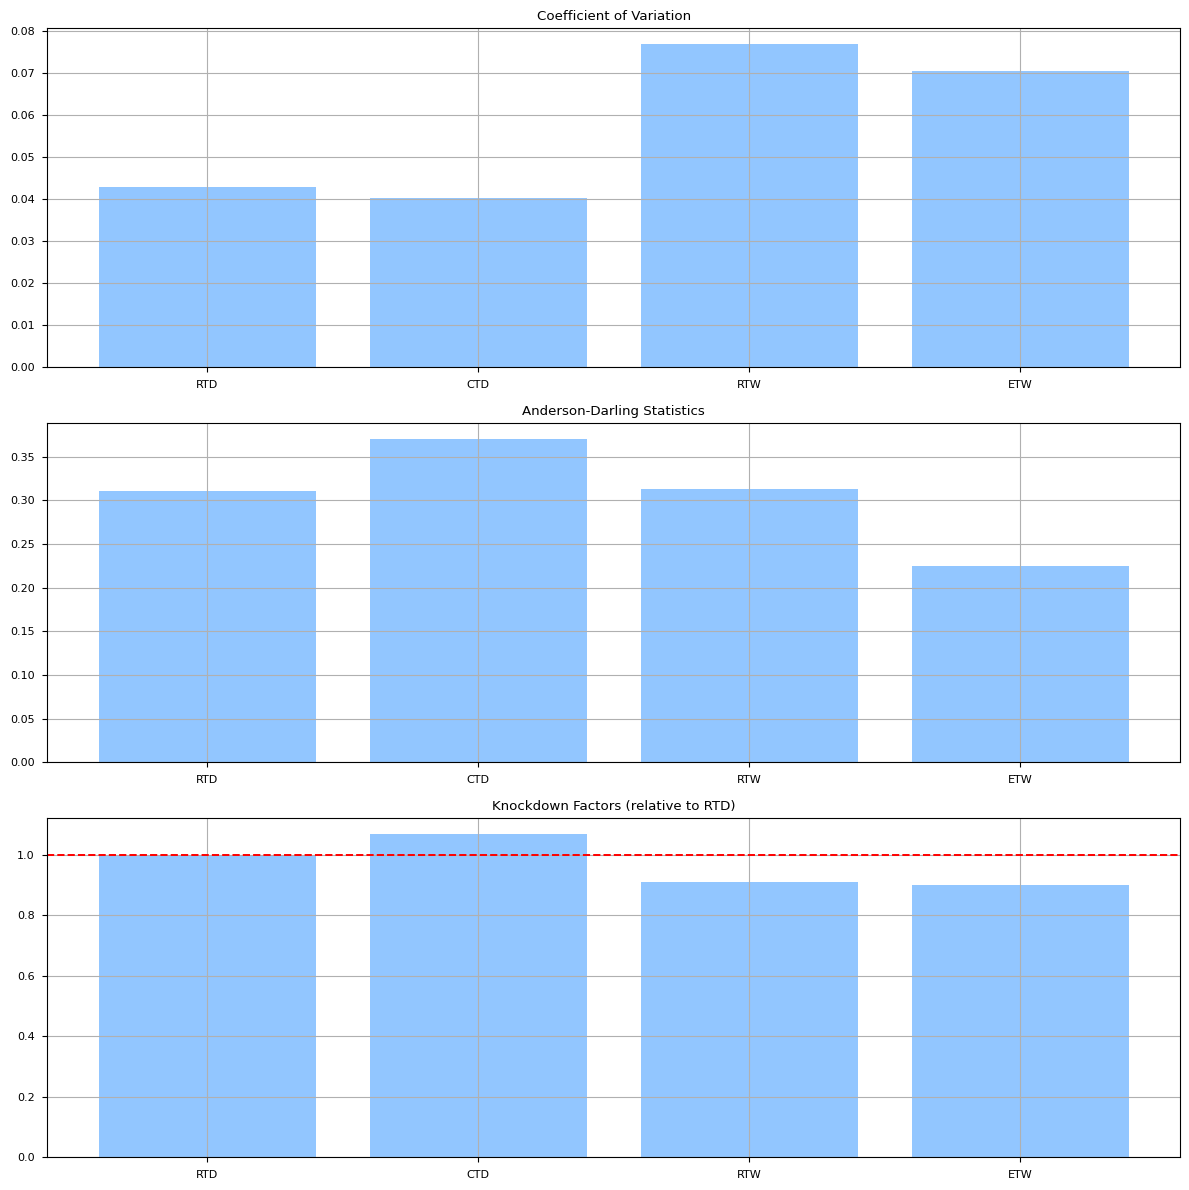

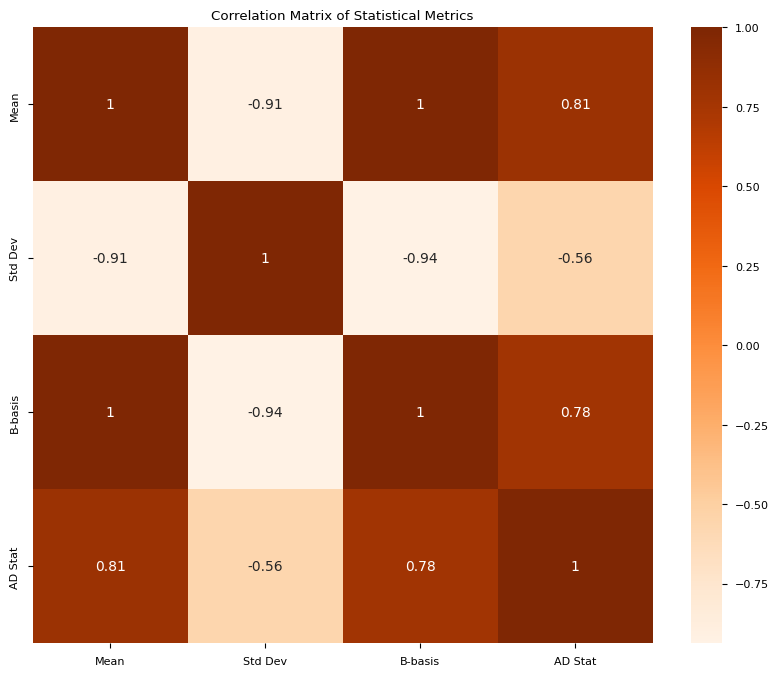

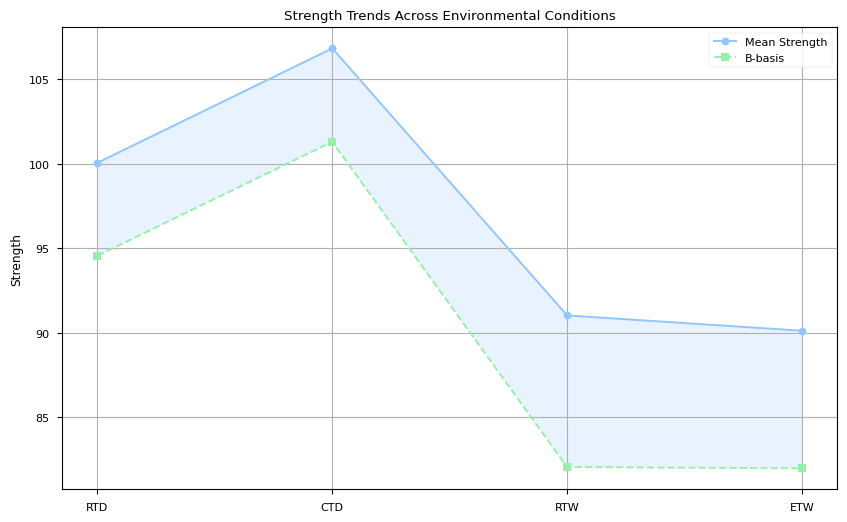

In [106]:
analysis_visualization(results)
statistical_summary_plot(results)
correlation_matrix(results)

# Additional analysis: Trend visualization
plt.style.use('seaborn-v0_8-pastel')
plt.figure(figsize=(10, 6))
conditions = list(results.keys())
means = [results[c]['mean'] for c in conditions]
b_basis = [results[c]['b_basis'] for c in conditions]

plt.plot(conditions, means, 'o-', label='Mean Strength')
plt.plot(conditions, b_basis, 's--', label='B-basis')
plt.fill_between(conditions, means, b_basis, alpha=0.2)
plt.title('Strength Trends Across Environmental Conditions')
plt.ylabel('Strength')
plt.grid(True)
plt.legend()
plt.show()

# Statistical summary data
statistical_summary_data = {
    'Mean': [results[c]['mean'] for c in conditions],
    'Std Dev': [results[c]['std'] for c in conditions],
    'B-basis': [results[c]['b_basis'] for c in conditions],
    'COV (%)': [results[c]['std']/results[c]['mean']*100 for c in conditions],
    'AD Stat': [results[c]['anderson_stat'] for c in conditions]
}

statistical_summary_df = pd.DataFrame(statistical_summary_data, index=conditions)
# print("\nStatistical Summary:")
# print(statistical_summary_df.round(3))

In [107]:
def plot_specimen_numbers_justification():
    """
    Create visualization with different style options:
    - 'modern': Clean, professional look with modern color scheme
    - 'scientific': Traditional scientific publication style
    - 'presentation': High contrast for presentations
    - 'corporate': Professional corporate look
    """
    
    
    plt.style.use('seaborn-v0_8-paper')
    colors = sns.color_palette("Set2", 3)
   

    # Number of specimens
    n_full = int(b_basis_sample_size())
    n_knockdown = int(knockdown_sample_size())
    n_validation = int(validation_sample_size())

    # figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(2, 2)

    # 1. Bar plot to compare approaches
    ax1 = fig.add_subplot(gs[0, :])
    approaches = ['Full B-basis', 'Factor Method', 'Reduced with Validation']
    specimens = [
        n_full * 4,
        n_full + (n_knockdown * 3),
        n_full + (n_knockdown * 3) + (3 * 3)
    ]

    bars = ax1.bar(approaches, specimens, color=colors)
    ax1.set_title('Total Specimen Count by Approach', pad=20, fontsize=12)
    ax1.set_ylabel('Number of Specimens', fontsize=10)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    ax1.grid(True, alpha=0.3)
    
    # 2. Breakdown by condition
    ax2 = fig.add_subplot(gs[1, 0])
    conditions = ['RTD', 'CTD', 'RTW', 'ETW']
    
    x = np.arange(len(conditions))
    width = 0.25

    full_basis = [n_full] * 4
    factor_method = [n_full] + [n_knockdown] * 3
    reduced_validation = [n_full] + [n_knockdown + 3] * 3

    rects1 = ax2.bar(x - width, full_basis, width, label='Full B-basis', color=colors[0])
    rects2 = ax2.bar(x, factor_method, width, label='Factor Method', color=colors[1])
    rects3 = ax2.bar(x + width, reduced_validation, width, label='Reduced with Validation', color=colors[2])

    ax2.set_title('Specimen Numbers by Condition', pad=20, fontsize=12)
    ax2.set_xlabel('Environmental Condition', fontsize=10)
    ax2.set_ylabel('Number of Specimens', fontsize=10)
    ax2.set_xticks(x)
    ax2.set_xticklabels(conditions)
    # ax2.legend()
    # ax2.grid(True, alpha=0.3)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)

    # Adjust layout to accommodate the legend
    plt.tight_layout()

    # 3. Statistical justification plot
    ax3 = fig.add_subplot(gs[1, 1])
    
    sample_sizes = range(5, 50)
    conf_levels = []
    for n in sample_sizes:
        conf = (1 - 2 * stats.t.sf(np.sqrt(n), df=n-1)) * 100
        conf_levels.append(conf)

    ax3.plot(sample_sizes, conf_levels, color=colors[0], linewidth=2)
    
    ax3.plot(n_full, conf_levels[n_full-5], 'o', color=colors[1], 
             markersize=10, label='Full B-basis')
    ax3.plot(n_knockdown, conf_levels[n_knockdown-5], 'o', 
             color=colors[2], markersize=10, label='Knockdown')

    ax3.set_title('Statistical Confidence vs Sample Size', pad=20, fontsize=12)
    ax3.set_xlabel('Sample Size', fontsize=10)
    ax3.set_ylabel('Confidence Level (%)', fontsize=10)
    ax3.grid(True)
    ax3.legend()

    # Add text box with justification
    textstr = '\n'.join((
        'Justification:',
        f'Full B-basis (n={n_full}):',
        '• 90% probability / 95% confidence',
        f'Knockdown (n={n_knockdown}):',
        '• Sufficient for mean estimation',
        f'Validation (n=3):',
        '• Verification of trends'
    ))

    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax3.text(.5, .5, textstr, transform=ax3.transAxes, fontsize=8, 
             verticalalignment='top', bbox=props)

    plt.tight_layout()
    
    plt.show()
    # Summary data frame
    summary_data = {
        'Approach': ['Full B-basis', 'Factor Method', 'Reduced with Validation'],
        'Total Specimens': specimens,
        'RTD': [n_full, n_full, n_full],
        'CTD': [n_full, n_knockdown, n_knockdown + 3],
        'RTW': [n_full, n_knockdown, n_knockdown + 3],
        'ETW': [n_full, n_knockdown, n_knockdown + 3]
    }
    
    summary_df = pd.DataFrame(summary_data)
    
    # Print summary
    # totals = summary_df.copy()
    # totals.loc['Total'] = ['Total'] + [totals[col].sum() for col in totals.columns[1:]]
    # print("\nSpecimen Count:")
    # print(totals)
    return summary_df

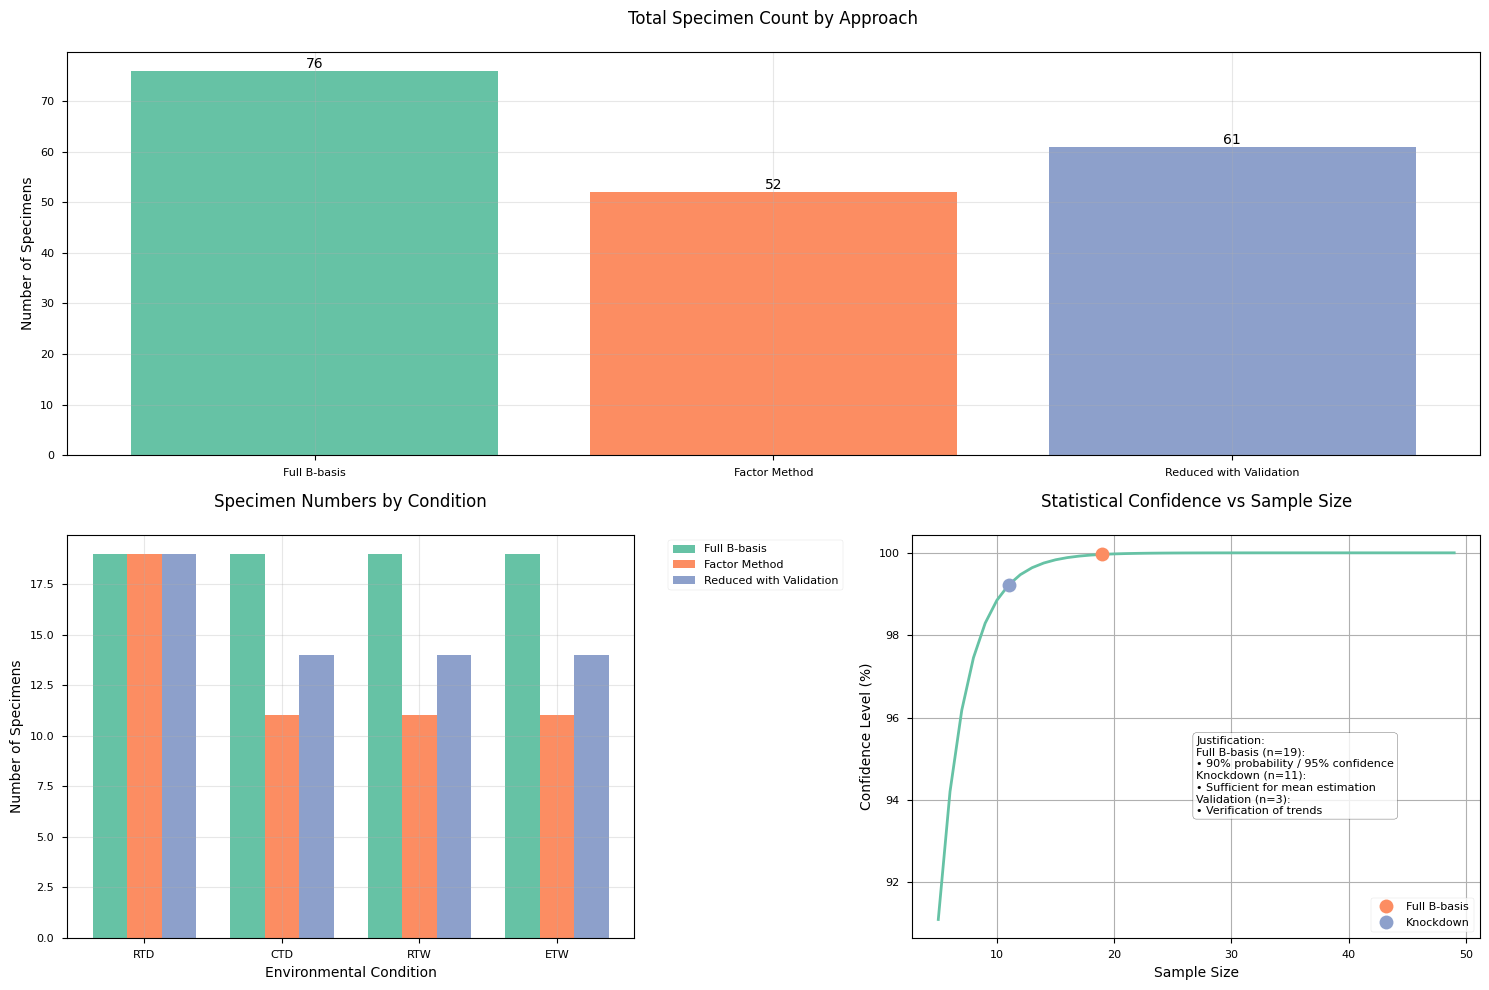

In [88]:
summary_df = plot_specimen_numbers_justification()